# A two layers network
In this exercises we will use a two layer (1 input, 1 hidden and 1 output) neural network to classify a two-class
data in the plane. Each point has a two dimensional position and a color (red or blue).

### Importing packages
We need two packages: numpy for the computation and matplotlib.pyplot for visualization

In [16]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(13)

### The data

The data are generated by the function load_dataset() shown below. 

In [17]:

def load_dataset():
    np.random.seed(1)
    m = 500 # number of points
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j
        
    X = X.T
    Y = Y.T

    return X, Y


To have an understanding of what kind of data we are deadling with we will plot it use matplotlib.
The X denotes the 2-d coordinates of the data and Y are the colors 0=blue, 1=red.
So $X[i,j]$ is the i$^{th}$ coordinate of the j${th}$ data point and $Y[j]$ is the corresponding color.

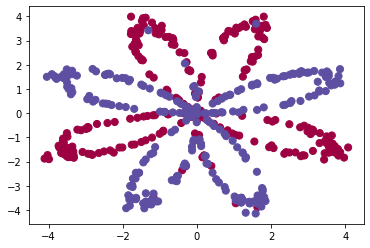

In [18]:
X,Y=load_dataset()
plt.scatter(X[0,:],X[1,:],c=Y[0,:],s=50,cmap=plt.cm.Spectral)

Having seen the data let us figure out the dimensions of the arrays we are dealing with
Since we have 500 data points and X contains the coordinates then X is a 2x500 matrix and Y contains
the colors so it is a 1x500. Try to determine the shape of X and Y 


In [19]:
X_shape=None
Y_shape=None
n_samples=None
print("X has shape "+str(X_shape))
print("Y has shape "+str(Y_shape))
print("Number of samples:"+str(n_samples))

X has shape None
Y has shape None
Number of samples:None


In a previous exercise we built a single node NN to fit the data and we obtained less that 50% accuracy
In this exercise we will use a 2-layer NN to get a better fit.

### The Model

![alt text](shallow-example.png "Title")

### Sigmoid function
First write the sigmoid function

In [20]:
def sigmoid(z):
    
    s=1/(1+np.exp(-z))

    return s

### Initializing the parameters
Since we have two layers we will need two weight matrices and two bias vectors. Consult the forward propagation equations shown below to be able to determine the shape of the parameters and therefore initialize them.
$\sigma$ is the sigmoid function defined above, $A^0=X$ is the input, $A^1$ and $A^2$ are the output of the first and second layers respectively. Recall that all the variables below (except the parameters) are vectorized version containing all the samples where the samples are column stacked. So X[:,0] is the input of the first (0) sample
Z1[0,0] is the output of the first node in the first layer when the input is the first sample, etc...

\begin{align*}
    Z^1&=W^1\cdot A^0+B^1\\
    A^1&=\sigma(Z^1)\\
    Z^2&=W^2\cdot A^1+B^2\\
    A^2&=\sigma(Z^2)
  \end{align*}
We initialize the weights randomly and the biases to zero. This is done in numpy by using the random.randn and zeros functions. To create an nxm matrix of random numbers we use np.random.randn(n,m) and to create an nxm matrix of zeros we use np.zeros((n,m))

In [21]:
def initialize_parameters(n_x,n_h,n_y):
    W1=np.random.randn(n_h,n_x)
    b1=np.zeros((n_h,1))
    W2=np.random.randn(n_y,n_h)
    b2=np.zeros((n_y,1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    return parameters

In [22]:
test_parameters=initialize_parameters(2,2,1)
print("W1="+str(test_parameters['W1']))
print("W2="+str(test_parameters['W2']))
print("b1="+str(test_parameters['b1']))
print("b2="+str(test_parameters['b2']))


W1=[[-0.15323616 -2.43250851]
 [ 0.50798434 -0.32403233]]
W2=[[-1.51107661 -0.87142207]]
b1=[[0.]
 [0.]]
b2=[[0.]]


#### Expected output

## Forward Propagation
To implement forward propagation recall that 
  \begin{align*}
    Z^1&=W^1\cdot A^0+b^1\\
    A^1&=\sigma(Z^1)\\
    Z^2&=W^2\cdot A^1+b^2\\
    A^2&=\sigma(Z^2)
  \end{align*}


In [23]:
def forward_propagation(X,parameters):
    #first retreive the parameters
    #from the dictionary 'parameters'
    W1=parameters['W1']
    W2=parameters['W2']
    b1=parameters['b1']
    b2=parameters['b2']
    #now compute the output of the layers
    Z1=np.dot(W1,X)+b1
    A1=sigmoid(Z1)
    Z2=np.dot(W2,A1)+b2
    A2=sigmoid(Z2)
    
    return A1,A2

### Back propagation
To compute the gradients recall the formulas from class.

\begin{align*}
   db^2&=\frac{1}{m}\sum_s(A^2-Y) & (1,1)\\
      dW2&=\frac{1}{m}(A^2-Y)\cdot {A^1}^T& (1,m)\times(m,n_h)=(1,n_h)\\
      db^1&=\frac{1}{m}\sum_s\left[{W^2}^T\cdot (A^2-Y)\right]*\sigma' & \sum_s (n_h,1)\times (1,m)=(n_h,1)\\
      dW^1&=\frac{1}{m}\left[\left({W^2}^T\cdot (A^2-Y)\right)*\sigma'\right]\cdot X^T &(n_h,1)\times(1,m)\times(m,2)=(n_h,2)
    \end{align*}
It is convenient to add temporary variables dZ2 and dZ1 defined as: $dZ2=A^2-Y$, $dZ1=\left({W^2}^T\cdot dZ2\right)*\sigma'$

In [24]:
def back_propagation(parameters,A1,A2,X,Y):
    #we will be dividing by the number of samples m
    m=X.shape[1]
    #Now retrieve W1 and W2 from 'parameters'
    W1=parameters['W1']
    W2=parameters['W2']
    # the derivative of the sigmoid
    gp=A1*(1-A1)
    #we will use some temporary variables
    dZ2=A2-Y
    dW2=np.dot(dZ2,A1.T)/m
    db2=np.sum(dZ2,axis=1,keepdims=True)/m
    dZ1=np.dot(W2.T,dZ2)*gp
    dW1=np.dot(dZ1,X.T)/m
    db1=np.sum(dZ1,axis=1,keepdims=True)/m
    
    grads={"dW1":dW1,"db1":db1,"dW2":dW2,"db2":db2}
    return grads

### Updating the parameters
For every iteration we need to update the parameters

In [25]:
def update_parameters(parameters,grads,learning_rate):
    #first retrieve the values from the dictionaries
    W1=parameters['W1']
    b1=parameters['b1']
    W2=parameters['W2']
    b2=parameters['b2']
    #retrieve derivatives from grads
    dW1=grads['dW1']
    db1=grads['db1']
    dW2=grads['dW2']
    db2=grads['db2']
    #update
    W1=W1-learning_rate*dW1
    b1=b1-learning_rate*db1
    W2=W2-learning_rate*dW2
    b2=b2-learning_rate*db2
    parameters={"W1":W1,"b1":b1,"W2":W2,"b2":b2}
    return parameters
    

### Computing the cost
Recall that for $m$ samples we defined the cross-entropy cost function as
\begin{align*}
cost=\frac{-1}{m}\sum_s Y*\log A^2+(1-Y)*\log (1-A^2)
\end{align*}

In [26]:
def compute_cost(A2,Y):
    m=Y.shape[1]
    logprob=Y*np.log(A2)+(1-Y)*np.log(1-A2)
    cost=-np.sum(logprob)/m
    cost=np.squeeze(cost)
    return cost

### Gradient Descent
Having implemented all the above functions now we can implement gradient descent. Note that we are
using the number of nodes in the hidden layer as a variable.


In [27]:
def GD(X,Y,n_h,num_iterations,learning_rate):
    #first determine the size of the input and output
    n_x=X.shape[0]
    n_y=Y.shape[0]
    #initialize the parameters
    parameters=initialize_parameters(n_x,n_h,n_y)
    #start the loop
    for i in range(num_iterations):
        #write your code here
        A1,A2=forward_propagation(X,parameters)
        grads=back_propagation(parameters,A1,A2,X,Y)
        parameters=update_parameters(parameters,grads,learning_rate)
        cost=compute_cost(A2,Y)
        if i % 500 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    #return the "learned" parameters
    return parameters

### Evaluating the results
At this point our network has learned the parameters. We test the predictions as follows: we compute the output $A^2$ and for every data point if the value of $A^2>0.5$ we predict red otherwise it is blue. After that we accumulate all the correct predictions. A prediction for data point $i$ is correct if $Y[i]=1$ and $A^2[i]=1$ or $Y[i]=0$ and 
$A^2[i]=0$. The sum of all correct predictions can be done nicely using the formula belwo
\begin{align*}
 Y\cdot {A^2}^T+(1-Y)\cdot(1-{A^2}^T)
\end{align*}

In [28]:
def predict(parameters,X):
    A1,A2=forward_propagation(X,parameters)
    #now compute the predictions from A2
    predictions=(A2>0.5)
    
    return predictions

In [29]:
#run GD
X,Y=load_dataset()
parameters=GD(X,Y,n_h=4,learning_rate=10,num_iterations=10000)
#predict the output and print the accuracy
predictions=predict(parameters,X)
correct=np.dot(Y,predictions.T)+np.dot(1-Y,1-predictions.T)
accuracy=100*float(correct)/float(Y.shape[1])
print("Accuracy="+str(accuracy))

Cost after iteration 0: 0.720465
Cost after iteration 500: 0.231445
Cost after iteration 1000: 0.217889
Cost after iteration 1500: 0.212477
Cost after iteration 2000: 0.209278
Cost after iteration 2500: 0.207046
Cost after iteration 3000: 0.205349
Cost after iteration 3500: 0.203991
Cost after iteration 4000: 0.202883
Cost after iteration 4500: 0.202111
Cost after iteration 5000: 0.201693
Cost after iteration 5500: 0.201315
Cost after iteration 6000: 0.200958
Cost after iteration 6500: 0.200617
Cost after iteration 7000: 0.200286
Cost after iteration 7500: 0.199964
Cost after iteration 8000: 0.199648
Cost after iteration 8500: 0.199336
Cost after iteration 9000: 0.199026
Cost after iteration 9500: 0.198716
Accuracy=93.2


### Visualizing the solution
We can visualize the solution by plotting the decision boundary

In [30]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)


ValueError: 'c' argument has 1 elements, which is not acceptable for use with 'x' with size 500, 'y' with size 500.